In [11]:
# 8.14 ResNet-18 모델 특징 추출

from torch import nn
from torchvision import models


model = models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1").eval() 
#입력줄기, 네 개의 스테이지, 평균풀링, 완전연결 계층으로 구성되므로 분류기를 제외하고 특징만 연산하는 계층을 features 변수로 저장
features = nn.Sequential(*list(model.children())[:-2])

In [20]:
# 8.15 특징 맵과 가중치 추출

from PIL import Image
from torchvision import transforms


transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ]
)

image = Image.open("../datasets/images/airplane.jpg")
target = transform(image).unsqueeze(0)
# print(target.shape) -> [1,3,224,224]

output = model(target) #[1,1000]로 해당 클래스에 대한 확률을 나타내는 벡터
class_idx = int(output.argmax())

weights = model.fc.weight[class_idx].reshape(-1, 1, 1) # [512]
features_output = features(target).squeeze() # squeeze 전에 [1,512,7,7]

print(weights.shape)
print(features_output.shape)

torch.Size([1, 1000])
torch.Size([512, 1, 1])
torch.Size([512, 7, 7])


In [18]:
# 8.16 클래스 활성화 맵 생성

import torch
from torch.nn import functional as F


cam = features_output * weights # [512,7,7]
cam = torch.sum(cam, dim=0) # [7,7]
# interpolate 함수를 통해 입력 이미지와 동일한 크기로 변경
cam = F.interpolate(
    input=cam.unsqueeze(0).unsqueeze(0), # [1,1,7,7]
    size=(image.size[1], image.size[0]), #[175,320]
    mode="bilinear", #양선형 보간 방식
).squeeze().detach().numpy() #[175,320]

(175, 320)


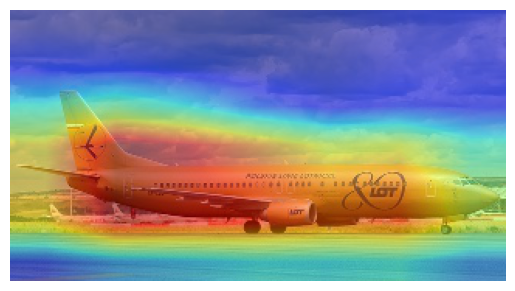

In [19]:
# 8.17 클래스 활성화 맵 시각화

import matplotlib.pyplot as plt


plt.imshow(image)
plt.imshow(cam, cmap="jet", alpha=0.5)
plt.axis("off")
plt.show()